In [84]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [4]:
path='C:\\Users\\dherschmann\\Documents\\GitHub\\Palmtree-Classifier'

In [67]:
try:
    os.mkdir(os.getcwd()+'/pics')
    os.mkdir(path+'/pics/training')
    os.mkdir(path+'/pics/testing')
    os.mkdir(path+'/pics/training/palm')
    os.mkdir(path+'/pics/training/snow')
    os.mkdir(path+'/pics/training/rest')
    os.mkdir(path+'/pics/testing/palm')
    os.mkdir(path+'/pics/testing/snow')
    os.mkdir(path+'/pics/testing/rest')
except:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    files = []
    for file in os.listdir(SOURCE):
        files.append(file)

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    #shuffled_set = random.sample(files, len(files))
    random.shuffle(files)
    shuffled_set = files
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [6]:
os.getcwd()

'C:\\Users\\dherschmann\\Documents\\GitHub\\Palmtree-Classifier'

In [68]:
PALM_SOURCE_DIR = path+"/allpalms/"
TRAINING_PALM_DIR = path+"/pics/training/palm/"
TESTING_PALM_DIR = path+"/pics/testing/palm/"
SNOW_SOURCE_DIR = path+"/allnieve/"
TRAINING_SNOW_DIR = path+"/pics/training/snow/"
TESTING_SNOW_DIR = path+"/pics/testing/snow/"
REST_SOURCE_DIR = path+"/allnone/"
TRAINING_REST_DIR =path+"/pics/training/rest/"
TESTING_REST_DIR =path+"/pics/testing/rest/"

split_size = .82
split_data(PALM_SOURCE_DIR, TRAINING_PALM_DIR, TESTING_PALM_DIR, split_size)
split_data(SNOW_SOURCE_DIR, TRAINING_SNOW_DIR, TESTING_SNOW_DIR, split_size)
split_data(REST_SOURCE_DIR, TRAINING_REST_DIR, TESTING_REST_DIR, split_size)

print(len(os.listdir(path+'/pics/training/palm/')))
print(len(os.listdir(path+"/pics/testing/palm/")))
print(len(os.listdir(path+"/pics/training/snow/")))
print(len(os.listdir(path+"/pics/testing/snow/")))
print(len(os.listdir(path+"/pics/training/rest/")))
print(len(os.listdir(path+"/pics/testing/rest/")))

393
87
407
90
772
170


In [69]:
total=len(os.listdir(path+'/allpalms/'))+len(os.listdir(path+'/allnieve/'))+len(os.listdir(path+'/allnone/'))
print('Anteil Palmen in Prozent: ',round(100*len(os.listdir(path+'/allpalms/'))/total,1))
print('Anteil Schnee in Prozent: ',round(100*len(os.listdir(path+'/allnieve/'))/total,1))
print('Anteil Rest in Prozent: ',round(100*len(os.listdir(path+'/allnone/'))/total,1))

Anteil Palmen in Prozent:  25.0
Anteil Schnee in Prozent:  25.9
Anteil Rest in Prozent:  49.1


In [70]:
TRAINING_DIR =path+"/pics/training/"
train_datagen =ImageDataGenerator(rescale=1/255.0,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') 
train_generator =train_datagen.flow_from_directory(TRAINING_DIR, batch_size=25,
                                                  class_mode='categorical',target_size=(300,300))

VALIDATION_DIR =path+"/pics/testing/" 
validation_datagen = ImageDataGenerator(rescale=1/255.0)
validation_generator =validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=25,
                                                            class_mode='categorical', target_size=(300,300))



validation_datagen = ImageDataGenerator(rescale=1/255)

Found 1572 images belonging to 3 classes.
Found 347 images belonging to 3 classes.


In [14]:
%matplotlib inline
def plot_acc_and_loss(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    ax1.plot(epochs, acc, 'r', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'r', label='Training Loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax2.legend()
    f.show()

In [79]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

def get_predictions_of_class(model, cls):
    pred=[]
    for image in os.listdir(path+'/pics/testing/'+cls):
        img = load(path+'/pics/testing/'+cls+'/'+image)
        a=model.predict(img)
        pred.append(np.argmax(a))
    return pred

In [102]:
modelMNV2.save('my_model.h5')

---
# Pre-trained MobileNetV2
---

In [1]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
preds=tf.keras.layers.Dense(3,activation='softmax')(x)

modelMNV2=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

for layer in modelMNV2.layers[:156]:
    layer.trainable=False
for layer in modelMNV2.layers[156:]:
    layer.trainable=True
    
modelMNV2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

step_size_train=train_generator.n//train_generator.batch_size

# modelMNV2.summary()

In [72]:
historyMNV2 = modelMNV2.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator, validation_steps=3)

Epoch 1/15
63/63 [==============================] - 234s 4s/step - loss: 0.7122 - acc: 0.6940 - val_loss: 0.4139 - val_acc: 0.8667
Epoch 2/15
63/63 [==============================] - 210s 3s/step - loss: 0.4669 - acc: 0.8206 - val_loss: 0.3611 - val_acc: 0.8800
Epoch 3/15
63/63 [==============================] - 236s 4s/step - loss: 0.4064 - acc: 0.8505 - val_loss: 0.3043 - val_acc: 0.9200
Epoch 4/15
63/63 [==============================] - 212s 3s/step - loss: 0.3722 - acc: 0.8607 - val_loss: 0.2921 - val_acc: 0.8933
Epoch 5/15
63/63 [==============================] - 203s 3s/step - loss: 0.3427 - acc: 0.8740 - val_loss: 0.3247 - val_acc: 0.8400
Epoch 6/15
63/63 [==============================] - 200s 3s/step - loss: 0.3269 - acc: 0.8823 - val_loss: 0.2575 - val_acc: 0.9333
Epoch 7/15
63/63 [==============================] - 192s 3s/step - loss: 0.3183 - acc: 0.8823 - val_loss: 0.2879 - val_acc: 0.8933
Epoch 8/15
63/63 [==============================] - 197s 3s/step - loss: 0.2964 - a

<ipython-input-14-e945e4138ec4>:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


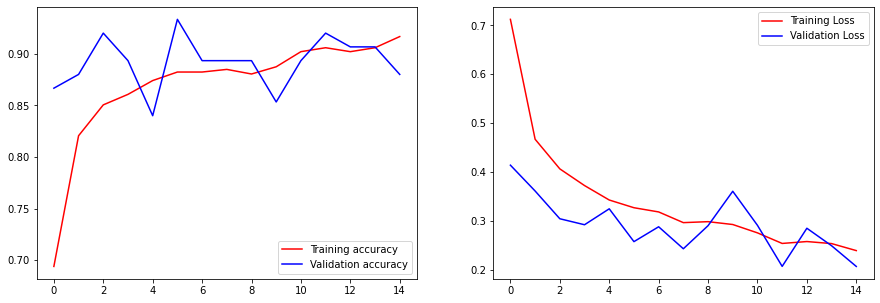

In [73]:
plot_acc_and_loss(historyMNV2)